# Data Wrangling

In [1]:
#Importing libraries needed 
import pandas as pd 
import numpy as np
import requests
import tweepy
import json
import matplotlib.pyplot as plt
import os
import re
import time
import io
from PIL import Image
from io import BytesIO
from os import path
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from IPython.display import Image
from IPython.core.display import HTML 
from tweepy import OAuthHandler
from timeit import default_timer as timer

In [2]:
#Tweeter Archive dataframe
df_arc= pd.read_csv('twitter-archive-enhanced.csv')
df_arc

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248...,5,10,None,None,None,None,None
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226...,6,10,a,None,None,None,None
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412...,9,10,a,None,None,None,None
2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285...,7,10,a,None,None,None,None


## Downloading and saving Image Predictions

In [3]:
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
r = requests.get(url)

In [4]:
file_name = url.split('/')[-1]
file_name

'image-predictions.tsv'

In [5]:
if not os.path.isfile(file_name):
    with open(file_name, 'wb') as f:
        f.write(r.content)

In [6]:
img_df = pd.read_csv('image-predictions.tsv', sep='\t')

In [7]:
img_df.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


## Twitter API [ Data Extraction and saving]

In [8]:
# Query Twitter API for each tweet in the Twitter archive and save JSON in a text file
# These are hidden to comply with Twitter's API terms and conditions
consumer_key = '***************************'
consumer_secret = '************************'
access_token = '***************************'
access_secret = '**************************'

auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True)

# NOTE TO STUDENT WITH MOBILE VERIFICATION ISSUES:
# df_1 is a DataFrame with the twitter_archive_enhanced.csv file. You may have to
# change line 17 to match the name of your DataFrame with twitter_archive_enhanced.csv
# NOTE TO REVIEWER: this student had mobile verification issues so the following
# Twitter API code was sent to this student from a Udacity instructor
# Tweet IDs for which to gather additional data via Twitter's API
tweet_ids = df_arc.tweet_id.values
len(tweet_ids)

2356

In [9]:
# Query Twitter's API for JSON data for each tweet ID in the Twitter archive
count = 0
fails_dict = {}
start = timer()
# Save each tweet's returned JSON as a new line in a .txt file
with open('tweet_json.txt', 'w') as outfile:
    # This loop will likely take 20-30 minutes to run because of Twitter's rate limit
    for tweet_id in tweet_ids:
        count += 1
        print(str(count) + ": " + str(tweet_id))
        try:
            tweet = api.get_status(tweet_id, tweet_mode='extended')
            print("Success")
            json.dump(tweet._json, outfile)
            outfile.write('\n')
        except tweepy.TweepError as e:
            print("Fail")
            fails_dict[tweet_id] = e
            pass
end = timer()
print(end - start)
print(fails_dict)

1: 892420643555336193
Success
2: 892177421306343426
Success
3: 891815181378084864
Success
4: 891689557279858688
Success
5: 891327558926688256
Success
6: 891087950875897856
Success
7: 890971913173991426
Success
8: 890729181411237888
Success
9: 890609185150312448
Success
10: 890240255349198849
Success
11: 890006608113172480
Success
12: 889880896479866881
Success
13: 889665388333682689
Success
14: 889638837579907072
Success
15: 889531135344209921
Success
16: 889278841981685760
Success
17: 888917238123831296
Success
18: 888804989199671297
Success
19: 888554962724278272
Success
20: 888202515573088257
Fail
21: 888078434458587136
Success
22: 887705289381826560
Success
23: 887517139158093824
Fail
24: 887473957103951883
Success
25: 887343217045368832
Success
26: 887101392804085760
Success
27: 886983233522544640
Success
28: 886736880519319552
Success
29: 886680336477933568
Success
30: 886366144734445568
Success
31: 886267009285017600
Success
32: 886258384151887873
Success
33: 886054160059072513


Fail
262: 842846295480000512
Success
263: 842765311967449089
Success
264: 842535590457499648
Success
265: 842163532590374912
Success
266: 842115215311396866
Success
267: 841833993020538882
Success
268: 841680585030541313
Success
269: 841439858740625411
Success
270: 841320156043304961
Success
271: 841314665196081154
Success
272: 841077006473256960
Success
273: 840761248237133825
Success
274: 840728873075638272
Success
275: 840698636975636481
Success
276: 840696689258311684
Success
277: 840632337062862849
Success
278: 840370681858686976
Success
279: 840268004936019968
Success
280: 839990271299457024
Success
281: 839549326359670784
Success
282: 839290600511926273
Success
283: 839239871831150596
Success
284: 838952994649550848
Success
285: 838921590096166913
Success
286: 838916489579200512
Success
287: 838831947270979586
Success
288: 838561493054533637
Success
289: 838476387338051585
Success
290: 838201503651401729
Success
291: 838150277551247360
Success
292: 838085839343206401
Success
293

Success
519: 810657578271330305
Success
520: 810284430598270976
Success
521: 810254108431155201
Success
522: 809920764300447744
Success
523: 809808892968534016
Success
524: 809448704142938112
Success
525: 809220051211603969
Success
526: 809084759137812480
Success
527: 808838249661788160
Success
528: 808733504066486276
Success
529: 808501579447930884
Success
530: 808344865868283904
Success
531: 808134635716833280
Success
532: 808106460588765185
Success
533: 808001312164028416
Success
534: 807621403335917568
Success
535: 807106840509214720
Success
536: 807059379405148160
Success
537: 807010152071229440
Success
538: 806629075125202948
Success
539: 806620845233815552
Success
540: 806576416489959424
Success
541: 806542213899489280
Success
542: 806242860592926720
Success
543: 806219024703037440
Success
544: 805958939288408065
Success
545: 805932879469572096
Success
546: 805826884734976000
Success
547: 805823200554876929
Success
548: 805520635690676224
Success
549: 805487436403003392
Success


Success
776: 776201521193218049
Success
777: 776113305656188928
Success
778: 776088319444877312
Success
779: 775898661951791106
Success
780: 775842724423557120
Success
781: 775733305207554048
Success
782: 775729183532220416
Success
783: 775364825476165632
Success
784: 775350846108426240
Success
785: 775096608509886464
Fail
786: 775085132600442880
Success
787: 774757898236878852
Success
788: 774639387460112384
Success
789: 774314403806253056
Success
790: 773985732834758656
Success
791: 773922284943896577
Success
792: 773704687002451968
Success
793: 773670353721753600
Success
794: 773547596996571136
Success
795: 773336787167145985
Success
796: 773308824254029826
Success
797: 773247561583001600
Success
798: 773191612633579521
Success
799: 772877495989305348
Success
800: 772826264096874500
Success
801: 772615324260794368
Success
802: 772581559778025472
Success
803: 772193107915964416
Success
804: 772152991789019136
Success
805: 772117678702071809
Success
806: 772114945936949249
Success
807

Success
1032: 745422732645535745
Success
1033: 745314880350101504
Success
1034: 745074613265149952
Success
1035: 745057283344719872
Success
1036: 744995568523612160
Success
1037: 744971049620602880
Success
1038: 744709971296780288
Success
1039: 744334592493166593
Success
1040: 744234799360020481
Success
1041: 744223424764059648
Success
1042: 743980027717509120
Success
1043: 743895849529389061
Success
1044: 743835915802583040
Success
1045: 743609206067040256
Success
1046: 743595368194129920
Success
1047: 743545585370791937
Success
1048: 743510151680958465
Success
1049: 743253157753532416
Success
1050: 743222593470234624
Success
1051: 743210557239623680
Success
1052: 742534281772302336
Success
1053: 742528092657332225
Success
1054: 742465774154047488
Success
1055: 742423170473463808
Success
1056: 742385895052087300
Success
1057: 742161199639494656
Success
1058: 742150209887731712
Success
1059: 741793263812808706
Success
1060: 741743634094141440
Success
1061: 741438259667034112
Success
10

Success
1281: 708834316713893888
Success
1282: 708810915978854401
Success
1283: 708738143638450176
Success
1284: 708711088997666817
Success
1285: 708479650088034305
Success
1286: 708469915515297792
Success
1287: 708400866336894977
Success
1288: 708356463048204288
Success
1289: 708349470027751425
Success
1290: 708149363256774660
Success
1291: 708130923141795840
Success
1292: 708119489313951744
Success
1293: 708109389455101952
Success
1294: 708026248782585858
Success
1295: 707995814724026368
Success
1296: 707983188426153984
Success
1297: 707969809498152960
Success
1298: 707776935007539200
Success
1299: 707741517457260545
Success
1300: 707738799544082433
Success
1301: 707693576495472641
Success
1302: 707629649552134146
Success
1303: 707610948723478529
Success
1304: 707420581654872064
Success
1305: 707411934438625280
Success
1306: 707387676719185920
Success
1307: 707377100785885184
Success
1308: 707315916783140866
Success
1309: 707297311098011648
Success
1310: 707059547140169728
Success
13

Success
1530: 690248561355657216
Success
1531: 690021994562220032
Success
1532: 690015576308211712
Success
1533: 690005060500217858
Success
1534: 689999384604450816
Success
1535: 689993469801164801
Success
1536: 689977555533848577
Success
1537: 689905486972461056
Success
1538: 689877686181715968
Success
1539: 689835978131935233
Success
1540: 689661964914655233
Success
1541: 689659372465688576
Success
1542: 689623661272240129
Success
1543: 689599056876867584
Success
1544: 689557536375177216
Success
1545: 689517482558820352
Success
1546: 689289219123089408
Success
1547: 689283819090870273
Success
1548: 689280876073582592
Success
1549: 689275259254616065
Success
1550: 689255633275777024
Success
1551: 689154315265683456
Success
1552: 689143371370250240
Success
1553: 688916208532455424
Success
1554: 688908934925697024
Success
1555: 688898160958271489
Success
1556: 688894073864884227
Success
1557: 688828561667567616
Success
1558: 688804835492233216
Success
1559: 688789766343622656
Success
15

Success
1779: 677895101218201600
Success
1780: 677716515794329600
Success
1781: 677700003327029250
Success
1782: 677698403548192770
Success
1783: 677687604918272002
Success
1784: 677673981332312066
Success
1785: 677662372920729601
Success
1786: 677644091929329666
Success
1787: 677573743309385728
Success
1788: 677565715327688705
Success
1789: 677557565589463040
Success
1790: 677547928504967168
Success
1791: 677530072887205888
Success
1792: 677335745548390400
Success
1793: 677334615166730240
Success
1794: 677331501395156992
Success
1795: 677328882937298944
Success
1796: 677314812125323265
Success
1797: 677301033169788928
Success
1798: 677269281705472000
Success
1799: 677228873407442944
Success
1800: 677187300187611136
Success
1801: 676975532580409345
Success
1802: 676957860086095872
Success
1803: 676949632774234114
Success
1804: 676948236477857792
Success
1805: 676946864479084545
Success
1806: 676942428000112642
Success
1807: 676936541936185344
Success
1808: 676916996760600576
Success
18

Success
2028: 671874878652489728
Success
2029: 671866342182637568
Success
2030: 671855973984772097
Success
2031: 671789708968640512
Success
2032: 671768281401958400
Success
2033: 671763349865160704
Success
2034: 671744970634719232
Success
2035: 671743150407421952
Success
2036: 671735591348891648
Success
2037: 671729906628341761
Success
2038: 671561002136281088
Success
2039: 671550332464455680
Success
2040: 671547767500775424
Success
2041: 671544874165002241
Success
2042: 671542985629241344
Success
2043: 671538301157904385
Success
2044: 671536543010570240
Success
2045: 671533943490011136
Success
2046: 671528761649688577
Success
2047: 671520732782923777
Success
2048: 671518598289059840
Success
2049: 671511350426865664
Success
2050: 671504605491109889
Success
2051: 671497587707535361
Success
2052: 671488513339211776
Success
2053: 671486386088865792
Success
2054: 671485057807351808
Success
2055: 671390180817915904
Success
2056: 671362598324076544
Success
2057: 671357843010908160
Success
20

Success
2277: 667443425659232256
Success
2278: 667437278097252352
Success
2279: 667435689202614272
Success
2280: 667405339315146752
Success
2281: 667393430834667520
Success
2282: 667369227918143488
Success
2283: 667211855547486208
Success
2284: 667200525029539841
Success
2285: 667192066997374976
Success
2286: 667188689915760640
Success
2287: 667182792070062081
Success
2288: 667177989038297088
Success
2289: 667176164155375616
Success
2290: 667174963120574464
Success
2291: 667171260800061440
Success
2292: 667165590075940865
Success
2293: 667160273090932737
Success
2294: 667152164079423490
Success
2295: 667138269671505920
Success
2296: 667119796878725120
Success
2297: 667090893657276420
Success
2298: 667073648344346624
Success
2299: 667070482143944705
Success
2300: 667065535570550784
Success
2301: 667062181243039745
Success
2302: 667044094246576128
Success
2303: 667012601033924608
Success
2304: 666996132027977728
Success
2305: 666983947667116034
Success
2306: 666837028449972224
Success
23

In [10]:
#Testing 
exp_tweet = api.get_status(df_arc.tweet_id[1000], tweet_mode = 'extended')
content = exp_tweet._json
content

{'created_at': 'Wed Jun 29 01:23:16 +0000 2016',
 'id': 747963614829678593,
 'id_str': '747963614829678593',
 'full_text': 'PUPPER NOOOOO BEHIND YOUUU 10/10 pls keep this pupper in your thoughts https://t.co/ZPfeRtOX0Q',
 'truncated': False,
 'display_text_range': [0, 70],
 'entities': {'hashtags': [],
  'symbols': [],
  'user_mentions': [],
  'urls': [],
  'media': [{'id': 747963600220917761,
    'id_str': '747963600220917761',
    'indices': [71, 94],
    'media_url': 'http://pbs.twimg.com/media/CmFM7ngXEAEitfh.jpg',
    'media_url_https': 'https://pbs.twimg.com/media/CmFM7ngXEAEitfh.jpg',
    'url': 'https://t.co/ZPfeRtOX0Q',
    'display_url': 'pic.twitter.com/ZPfeRtOX0Q',
    'expanded_url': 'https://twitter.com/dog_rates/status/747963614829678593/photo/1',
    'type': 'photo',
    'sizes': {'thumb': {'w': 150, 'h': 150, 'resize': 'crop'},
     'medium': {'w': 937, 'h': 632, 'resize': 'fit'},
     'small': {'w': 680, 'h': 459, 'resize': 'fit'},
     'large': {'w': 937, 'h': 632, '

In [11]:
content.keys()

dict_keys(['created_at', 'id', 'id_str', 'full_text', 'truncated', 'display_text_range', 'entities', 'extended_entities', 'source', 'in_reply_to_status_id', 'in_reply_to_status_id_str', 'in_reply_to_user_id', 'in_reply_to_user_id_str', 'in_reply_to_screen_name', 'user', 'geo', 'coordinates', 'place', 'contributors', 'is_quote_status', 'retweet_count', 'favorite_count', 'favorited', 'retweeted', 'possibly_sensitive', 'possibly_sensitive_appealable', 'lang'])

In [12]:
exp_tweet.full_text

'PUPPER NOOOOO BEHIND YOUUU 10/10 pls keep this pupper in your thoughts https://t.co/ZPfeRtOX0Q'

In [13]:
#creating An API DataFrame
df_list = []

with open('tweet_json.txt', 'r') as f:
    for line in f:
        tweet = json.loads(line)
        tweet_id = tweet['id']
        retweet_count = tweet['retweet_count']
        fav_count = tweet['favorite_count']
        df_list.append({'tweet_id':tweet_id,
                       'retweet_count': retweet_count,
                       'favorite_count': fav_count})
        
api_df = pd.DataFrame(df_list)
api_df.head()

,tweet_id,retweet_count,favorite_count
0,892420643555336193,7421,35161
1,892177421306343426,5519,30435
2,891815181378084864,3645,22887
3,891689557279858688,7595,38454
4,891327558926688256,8173,36719


In [14]:
api_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2330 entries, 0 to 2329
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   tweet_id        2330 non-null   int64
 1   retweet_count   2330 non-null   int64
 2   favorite_count  2330 non-null   int64
dtypes: int64(3)
memory usage: 54.7 KB


# Assessing Data

 ### Twitter Archive (df_arc)
   
   #### Visual Assesment
  
`1. text column contain 2 variable (text + short url)`
   
S. adjust a column for short url and clean the text column.
   
`2. 'doggo', 'floofer', 'pupper', 'puppo' column have a tidiness issue which reflect the quality of the presented data.`
   
S. combine the above columns into 1 categorical colmns ---- > ' dog-style '
   
`3. rating to some coresponding tweets are so high [idx] of those are is follow : 188, 189, 290, 313, 340 433, 695, 902,           979, 1120, 1202, 1228, 1254, 1274, 1351, 1433, 1634, 1635, 1779, 1843, 2074 ---- Quality Issue .`
   
S. Dividing those number upon the number of retweets for each tweet
   
`4. dealling with none value`

S. not sure of replacing them will be a good idea but it could work for now if we want to keep the data ambigousity
   ,is it okay if we removed some columns that we think it would be unnessesary keeping them 
  
`5. blanked URL In expanded_urls column if needed.`
   
`6. noticed there in name colmn that there's inacurracy issue with some name inserted as "a" , we have to do further invistigation upon them programatically to asses it's scale.`

   #### Programatic Assesment 

In [15]:
df_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

# Notes 
##### `1.tweet_id is an integer number, it could not be a good indicator though if we plan to use it for next stages`

#####  S.  it should be unique Identifier so converting tweet_id from int to string 

#####  `2.times stamp is an object it should have a clear classification as its an indicator of Time`

#####  S. converts times_stamp to Time 

In [16]:
df_arc.name.value_counts()

None       745
a           55
Charlie     12
Lucy        11
Cooper      11
          ... 
Tebow        1
Lucia        1
Benny        1
Vince        1
Emanuel      1
Name: name, Length: 957, dtype: int64

In [17]:
df_arc.nunique()

tweet_id                      2356
in_reply_to_status_id           77
in_reply_to_user_id             31
timestamp                     2356
source                           4
text                          2356
retweeted_status_id            181
retweeted_status_user_id        25
retweeted_status_timestamp     181
expanded_urls                 2218
rating_numerator                40
rating_denominator              18
name                           957
doggo                            2
floofer                          2
pupper                           2
puppo                            2
dtype: int64

# self notes:- 
### note:

##### `it's not necessary to have a coresponding action to those with colmn name as follow : `

##### ['in_reply_to_status_id']
##### ['in_reply_to_user_id']
##### ['retweeted_status_id']
##### ['retweeted_status_user_id']
##### ['retweeted_status_timestamp']

##### So we ignore them for now and check later what can we do with them.

In [18]:
df_arc.source.value_counts()

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     2221
<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>                          91
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                       33
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>      11
Name: source, dtype: int64

#### - We could Extract the source platform inside the URl pattern to conduct more effeicnt analysis later  and converting them from `str` to `category`data type

In [19]:
df_arc.isnull().sum()

tweet_id                         0
in_reply_to_status_id         2278
in_reply_to_user_id           2278
timestamp                        0
source                           0
text                             0
retweeted_status_id           2175
retweeted_status_user_id      2175
retweeted_status_timestamp    2175
expanded_urls                   59
rating_numerator                 0
rating_denominator               0
name                             0
doggo                            0
floofer                          0
pupper                           0
puppo                            0
dtype: int64

### Note 
##### `expanded_urls   59 missing Entry`

In [20]:
df_arc.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


### Note :

-` Rating  is unconsistant` as it's 10 in the first and secound and third quartil ---- but in the forth it reached 170 --- inconsistance with others ----- this is giving us some insights since the rating_numerator has the same issue in the forth quartile.{detials : we can extract the factor from those denominators to the substance that allow us to divide the numerator by those factors, to reduce the inconsistancy there 

In [21]:
arc_ind = df_arc.copy()

In [22]:
arc_ind

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248...,5,10,None,None,None,None,None
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226...,6,10,a,None,None,None,None
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412...,9,10,a,None,None,None,None
2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285...,7,10,a,None,None,None,None


In [23]:
arc_ind.nlargest(20, 'rating_numerator')[['text', 'rating_numerator', 'rating_denominator']]

,text,rating_numerator,rating_denominator
979,This is Atticus. He's quite simply America af....,1776,10
313,@jonnysun @Lin_Manuel ok jomny I know you're e...,960,0
189,@s8n You tried very hard to portray this good ...,666,10
188,@dhmontgomery We also gave snoop dogg a 420/10...,420,10
2074,After so many requests... here you go.\n\nGood...,420,10
1120,Say hello to this unbelievably well behaved sq...,204,170
290,@markhoppus 182/10,182,10
902,Why does this never happen at my front door......,165,150
1779,IT'S PUPPERGEDDON. Total of 144/120 ...I think...,144,120
1634,"Two sneaky puppers were not initially seen, mo...",143,130


In [24]:
arc_ind.nsmallest(40, 'rating_numerator')[['text', 'rating_numerator', 'rating_denominator']]

,text,rating_numerator,rating_denominator
315,When you're so blinded by your systematic plag...,0,10
1016,"PUPDATE: can't see any. Even if I could, I cou...",0,10
605,RT @dog_rates: Not familiar with this breed. N...,1,10
1446,After reading the comments I may have overesti...,1,10
1869,What kind of person sends in a picture without...,1,10
1940,The millennials have spoken and we've decided ...,1,10
2038,After 22 minutes of careful deliberation this ...,1,10
2091,Flamboyant pup here. Probably poisonous. Won't...,1,10
2261,Never seen dog like this. Breathes heavy. Tilt...,1,10
2335,This is an Albanian 3 1/2 legged Episcopalian...,1,2


In [25]:
arc_ind['rating_denominator'].nunique()

18

In [26]:
arc_ind.nsmallest(20, 'rating_denominator')[['text', 'rating_numerator', 'rating_denominator']]

,text,rating_numerator,rating_denominator
313,@jonnysun @Lin_Manuel ok jomny I know you're e...,960,0
2335,This is an Albanian 3 1/2 legged Episcopalian...,1,2
516,Meet Sam. She smiles 24/7 &amp; secretly aspir...,24,7
0,This is Phineas. He's a mystical boy. Only eve...,13,10
1,This is Tilly. She's just checking pup on you....,13,10
2,This is Archie. He is a rare Norwegian Pouncin...,12,10
3,This is Darla. She commenced a snooze mid meal...,13,10
4,This is Franklin. He would like you to stop ca...,12,10
5,Here we have a majestic great white breaching ...,13,10
6,Meet Jax. He enjoys ice cream so much he gets ...,13,10


In [27]:
arc_ind.nlargest(20, 'rating_denominator')[['text', 'rating_numerator', 'rating_denominator']]

,text,rating_numerator,rating_denominator
1120,Say hello to this unbelievably well behaved sq...,204,170
902,Why does this never happen at my front door......,165,150
1634,"Two sneaky puppers were not initially seen, mo...",143,130
1779,IT'S PUPPERGEDDON. Total of 144/120 ...I think...,144,120
1635,Someone help the girl is being mugged. Several...,121,110
1228,Happy Saturday here's 9 puppers on a bench. 99...,99,90
1254,Here's a brigade of puppers. All look very pre...,80,80
1843,Here we have an entire platoon of puppers. Tot...,88,80
433,The floofs have been released I repeat the flo...,84,70
1202,This is Bluebert. He just saw that both #Final...,50,50


#### `Visual assesment of those deviations`

<br>45  ---- 13.5 not 5 .
<br>516 ---- not rating so to be `dropped`.
<br>695 ---- 9.75 not 75 .
<br>763 ---- 11.27 not 27 .
<br>1689 --- 9.5 not 5 .
<br>1712 --- 11.26 not 26
<br>2074 ---- there's no dog here "snoop dog the singer" so to be `dropped`.

##### `Those we divide them by their approximatly number of rating the got by making the `rating_denominator` consistant and adjusting them to the same ratio implied:`
    
188
189
290
313
340
433
902
979
1120
1165
1202
1228
1254
1274
1351
1433
1459
1598
1634
1635
1663
1779
1843
2335

In [28]:
df_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [29]:
df_arc['name'].value_counts()

None       745
a           55
Charlie     12
Lucy        11
Cooper      11
          ... 
Tebow        1
Lucia        1
Benny        1
Vince        1
Emanuel      1
Name: name, Length: 957, dtype: int64

- noticed there in `name colmn there's 745 of None values and there's inacurracy issue with some name` inserted as "a" , we have to do further invistigation upon them programatically to asses it's scale.

In [30]:
df_arc['doggo'].value_counts()

None     2259
doggo      97
Name: doggo, dtype: int64

In [31]:
df_arc['floofer'].value_counts()

None       2346
floofer      10
Name: floofer, dtype: int64

In [32]:
df_arc['pupper'].value_counts()

None      2099
pupper     257
Name: pupper, dtype: int64

In [33]:
df_arc['puppo'].value_counts()

None     2326
puppo      30
Name: puppo, dtype: int64

##### - `doggo', 'floofer', 'pupper', 'puppo' column have a tidiness issue`which reflect the quality of the presented data,combine the above columns into 1 categorical colmns and convert them `categorical data`type 
##### -  there is missing values in `doggo`, `floofer`, `pupper`,`puppo` column.

## Image Prediction
 ### Visual Assesment ( unapplicaple)
 
 ### Programatical Assesment

In [34]:
img_df

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
...,...,...,...,...,...,...,...,...,...,...,...,...
2070,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True
2071,891689557279858688,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
2072,891815181378084864,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
2073,892177421306343426,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True


### Notes : -
#### `Column names are non-descriptive `
#### S. Changing thier coresponding names 

In [35]:
img_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


### Note :- 
#### `Twitter id` as we previously checked in the arc_df it should be converted to string (object) as identifer object not int.

In [36]:
img_df.isnull().sum()

tweet_id    0
jpg_url     0
img_num     0
p1          0
p1_conf     0
p1_dog      0
p2          0
p2_conf     0
p2_dog      0
p3          0
p3_conf     0
p3_dog      0
dtype: int64

In [37]:
img_df.duplicated().sum()

0

In [38]:
img_df.nunique()

tweet_id    2075
jpg_url     2009
img_num        4
p1           378
p1_conf     2006
p1_dog         2
p2           405
p2_conf     2004
p2_dog         2
p3           408
p3_conf     2006
p3_dog         2
dtype: int64

### Note :-
##### `we only have 2009 image yet we didnt chech for retweet images that could be conducted there. `
##### we have here 2075 and there 2356

In [39]:
img_df.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


## API Data 

In [40]:
api_df

,tweet_id,retweet_count,favorite_count
0,892420643555336193,7421,35161
1,892177421306343426,5519,30435
2,891815181378084864,3645,22887
3,891689557279858688,7595,38454
4,891327558926688256,8173,36719
...,...,...,...
2325,666049248165822465,38,94
2326,666044226329800704,122,261
2327,666033412701032449,39,107
2328,666029285002620928,41,118


### Note : -
#### `we have here only 2331 that was drived from total of 2356 record with there corsponding retweet and favoutite count. `

In [41]:
api_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2330 entries, 0 to 2329
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   tweet_id        2330 non-null   int64
 1   retweet_count   2330 non-null   int64
 2   favorite_count  2330 non-null   int64
dtypes: int64(3)
memory usage: 54.7 KB


#### `tweet_id converted to object`

# Full Assesment Coclusions [Summary]

## 1.Conducted `Quality issues` : -

### 1.1 `Archive` table

**Consistancy

- `Tweet_id` is an integer number, it could not be a good indicator though if we plan to use it for next stages, it should be unique Identifier - Converting tweet_id from int to string.

- `Timestamp` is an object it should have a clear classification as its an indicator of Time - validity - converts times_stamp to Time.

- `text` column contain 2 variable `(text + short url)`

- Misssing values in `doggo`, `floofer`, `pupper`,`puppo` column.

- Dealling with none value s. not sure of replacing them will be a good idea but it could work for now if we want to keep the data ambigousity by droping `in_reply_to_status_id` `in_reply_to_user_id` `retweeted_status_id` `retweeted_status_user_id` `retweeted_status_timestamp`

- From `source` column extract the source platform inside the URl pattern to conduct more effeicnt analysis later.

**Accuracy

- Erroneous names in `name` column : noticed there in name colmn that there's inacurracy issue with some name inserted as "a" , we have to do further invistigation upon them programatically to asses it's scale.

- `rating_numerator`, `rating_denominator` columns have some incorrect information under thier values and the represented rating in some cases is critical so it should be adjusted.

**Completeness

- Checking those tweets in the `archive` that have Image from the `Image_prediction` data and deleting those tweets that have no image.

- Removing the `retweet` and `replies` since we only need the orginal ones here.

- Blanked URL In expanded_urls column if needed ---- ** `expanded_urls`   59 missing Entry 

- After conducting `doggo`, `floofer`, `pupper`, `puppo` into one column should be converted to `categorical data` type - `validity`.

- Larg number of missing values in those column `['in_reply_to_status_id']['in_reply_to_user_id']['retweeted_status_id']['retweeted_status_user_id']['retweeted_status_timestamp']` + `['doggo', 'floofer', 'pupper', 'puppo' ]`.

**Valdity

- Erroneous datatype after conducting `dog_stage` column and modifing `Source` column, converting them from `str` to `category`data type

### 1.2 `Image prediction`  table

- `tweet_id` as we previously checked in the `arc_df` it should be converted to string (object) as identifer `object` not int.

- Column names are non-descriptive `'p1', 'p1_conf', 'p1_dog', 'p2', 'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog'`.

- replace the `underscore` with `space` and `title` for `p1,p2,p3` values.

- We only have 2009 image yet we didnt check for retweet images that could be conducted there,we have here 2075 and there 2356.

### 1.3 `API data`  table

- `Tweet_id` converted to `object`.

- Only 2325 that was drived from total of 2356 record with there corsponding retweet and favoutite count. 

## 2.Conducted `Tidiness Issues` : -

### 2.1`Archive` table

- doggo', 'floofer', 'pupper', 'puppo' column have a tidiness issue which reflect the quality of the presented data,combine the above columns into 1 categorical colmns.

### 2.2`Image prediction` table

- P1 and P2,P3 Are all bread predicions

### 2.3 `API data` table

- considered as interactioal data for Archieve data so should be merged to conduct better analysis in term of relavancy.

# Clean

In [42]:
# making copy and arranging data for cleaning stage.
arc_clean = df_arc.copy()
img_clean = img_df.copy()
api_clean = api_df.copy()

## 1.`Quality issues`
###  `tweet_id`  across all `DataFrames`

##### Define
Converting tweet_id from int to string using `astype`

##### Code

In [43]:
arc_clean.tweet_id = arc_clean.tweet_id.astype(str)
img_clean.tweet_id = img_clean.tweet_id.astype(str)
api_clean.tweet_id = api_clean.tweet_id.astype(str)

##### Test

In [44]:
arc_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   object 
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [45]:
img_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   object 
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(1), object(5)
memory usage: 152.1+ KB


In [46]:
api_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2330 entries, 0 to 2329
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   tweet_id        2330 non-null   object
 1   retweet_count   2330 non-null   int64 
 2   favorite_count  2330 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 54.7+ KB


### We only have 2009 image yet we didnt check for retweet images that could be conducted there,we have here 2075 record and there 2356 in the archive, and we only conducted 2331 record with API that was drived from total of 2356 record with there corsponding retweet and favoutite count.

#### Define
Refinng the orginal tweets that include Images and sorting the API data to be complied with the rest of the DataFrames.
#### Code

In [47]:
# creating a list of tweet_ids with images "tweets_with_image" and confirming its length
tweets_with_image = list(img_clean.tweet_id.unique())
tweets_with_image

['666020888022790149',
 '666029285002620928',
 '666033412701032449',
 '666044226329800704',
 '666049248165822465',
 '666050758794694657',
 '666051853826850816',
 '666055525042405380',
 '666057090499244032',
 '666058600524156928',
 '666063827256086533',
 '666071193221509120',
 '666073100786774016',
 '666082916733198337',
 '666094000022159362',
 '666099513787052032',
 '666102155909144576',
 '666104133288665088',
 '666268910803644416',
 '666273097616637952',
 '666287406224695296',
 '666293911632134144',
 '666337882303524864',
 '666345417576210432',
 '666353288456101888',
 '666362758909284353',
 '666373753744588802',
 '666396247373291520',
 '666407126856765440',
 '666411507551481857',
 '666418789513326592',
 '666421158376562688',
 '666428276349472768',
 '666430724426358785',
 '666435652385423360',
 '666437273139982337',
 '666447344410484738',
 '666454714377183233',
 '666644823164719104',
 '666649482315059201',
 '666691418707132416',
 '666701168228331520',
 '666739327293083650',
 '666776908

In [48]:
len(tweets_with_image)

2075

In [49]:
# confirming that all the tweets with images exist in the archive dataset
len(tweets_with_image) == arc_clean.tweet_id.isin(tweets_with_image).sum()

True

In [50]:
# Cleaning in action ;)
arc_clean = arc_clean[arc_clean.tweet_id.isin(tweets_with_image)]

In [51]:
# Throwback to the archive dataset to extract the tweets that include data in the retweet_status_id.
retweet_entries = arc_clean.retweeted_status_id.notnull()
arc_clean[retweet_entries].shape[0]

81

In [52]:
arc_clean = arc_clean[~retweet_entries]

In [53]:
# Extracting replies entries with the same method as the retweets
replies_entries = arc_clean.in_reply_to_status_id.notnull()
arc_clean[replies_entries].shape[0]

23

In [54]:
# Follow the same logic as above but with the column in_reply_to_status_id
arc_clean = arc_clean[~replies_entries]

In [55]:
# Now we check the image_prediction table for extra tweet ids not in the archive table
np.logical_not(img_clean.tweet_id.isin(list(arc_clean.tweet_id)))

0       False
1       False
2       False
3       False
4       False
        ...  
2070    False
2071    False
2072    False
2073    False
2074    False
Name: tweet_id, Length: 2075, dtype: bool

In [56]:
# Dropping the retweets and replies ids from the image prediction dataframe
img_clean[~np.logical_not(img_clean.tweet_id.isin(list(arc_clean.tweet_id)))]

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
...,...,...,...,...,...,...,...,...,...,...,...,...
2070,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True
2071,891689557279858688,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
2072,891815181378084864,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
2073,892177421306343426,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True


In [57]:
arc_id_list = list(arc_clean.tweet_id.unique())

In [58]:
len(arc_id_list) == img_clean.tweet_id.isin(arc_id_list).sum()

True

In [59]:
img_clean = img_clean[img_clean.tweet_id.isin(arc_id_list)]

In [60]:
api_clean = api_clean[api_clean.tweet_id.isin(arc_id_list)]

#### Test

In [61]:
arc_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1971 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    1971 non-null   object 
 1   in_reply_to_status_id       0 non-null      float64
 2   in_reply_to_user_id         0 non-null      float64
 3   timestamp                   1971 non-null   object 
 4   source                      1971 non-null   object 
 5   text                        1971 non-null   object 
 6   retweeted_status_id         0 non-null      float64
 7   retweeted_status_user_id    0 non-null      float64
 8   retweeted_status_timestamp  0 non-null      object 
 9   expanded_urls               1971 non-null   object 
 10  rating_numerator            1971 non-null   int64  
 11  rating_denominator          1971 non-null   int64  
 12  name                        1971 non-null   object 
 13  doggo                       1971 

In [62]:
img_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1971 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  1971 non-null   object 
 1   jpg_url   1971 non-null   object 
 2   img_num   1971 non-null   int64  
 3   p1        1971 non-null   object 
 4   p1_conf   1971 non-null   float64
 5   p1_dog    1971 non-null   bool   
 6   p2        1971 non-null   object 
 7   p2_conf   1971 non-null   float64
 8   p2_dog    1971 non-null   bool   
 9   p3        1971 non-null   object 
 10  p3_conf   1971 non-null   float64
 11  p3_dog    1971 non-null   bool   
dtypes: bool(3), float64(3), int64(1), object(5)
memory usage: 159.8+ KB


In [63]:
api_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1963 entries, 0 to 2329
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   tweet_id        1963 non-null   object
 1   retweet_count   1963 non-null   int64 
 2   favorite_count  1963 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.3+ KB


## 1.1 `Archive ` Qaulity

### `text` column contain 2 variable (text + short url)

#### Define
adjust a column for `short url` and clean the `text column` 

##### Code

In [64]:
# create short_urls column 
arc_clean['short_urls'] = arc_clean.text.apply(lambda x :x.strip().split(' ')[-1])
# split the text column 
arc_clean.text = arc_clean.text.apply(lambda x:x.split('https:')[0])
# ordering columns
column_names = ['tweet_id','in_reply_to_status_id','in_reply_to_user_id','timestamp', 'source', 'text', 'retweeted_status_id','retweeted_status_user_id','retweeted_status_timestamp','expanded_urls','short_urls','rating_numerator', 'rating_denominator', 'name','doggo','floofer','pupper','puppo']
arc_clean = arc_clean.reindex(columns= column_names)

#### Test

In [65]:
arc_clean.sample()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,short_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
398,825026590719483904,NaN,NaN,2017-01-27 17:04:02 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Say hello to Pablo. He's one gorgeous puppo. A...,NaN,NaN,NaN,https://www.gofundme.com/my-puppys-double-cata...,https://t.co/IhW0JKf7kc,12,10,Pablo,None,None,None,puppo


### - Extract the `source` platform inside the URl pattern to be used later in our Analysis.

##### Define
Extract the source platform inside the URl `.str.extract`

##### Code

In [66]:
arc_clean['source'] = df_arc['source'].str.extract('>(.*)<')

##### Test

In [67]:
arc_clean.source

0       Twitter for iPhone
1       Twitter for iPhone
2       Twitter for iPhone
3       Twitter for iPhone
4       Twitter for iPhone
               ...        
2351    Twitter for iPhone
2352    Twitter for iPhone
2353    Twitter for iPhone
2354    Twitter for iPhone
2355    Twitter for iPhone
Name: source, Length: 1971, dtype: object

### - Remove the extra +0000 in `timestamp` before converting to datetype since `str.strip` only work on string.
### - `timestamp` is an object it should have a clear classification so converts times_stamp to Datetime data type.

##### Define
Remove the extra +0000 using `str.strip`,
 then Convert `timestamp` to Datetime data type using `.to_datetime`.

##### Code

In [68]:
# remove +0000 from timestamp column
arc_clean.timestamp = arc_clean.timestamp.str.strip('+0000')
# Convert timestamp to Datetime data type
arc_clean['timestamp'] = pd.to_datetime(arc_clean.timestamp)

##### Test

In [69]:
arc_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1971 entries, 0 to 2355
Data columns (total 18 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   tweet_id                    1971 non-null   object        
 1   in_reply_to_status_id       0 non-null      float64       
 2   in_reply_to_user_id         0 non-null      float64       
 3   timestamp                   1971 non-null   datetime64[ns]
 4   source                      1971 non-null   object        
 5   text                        1971 non-null   object        
 6   retweeted_status_id         0 non-null      float64       
 7   retweeted_status_user_id    0 non-null      float64       
 8   retweeted_status_timestamp  0 non-null      object        
 9   expanded_urls               1971 non-null   object        
 10  short_urls                  1971 non-null   object        
 11  rating_numerator            1971 non-null   int64       

In [70]:
arc_clean.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,short_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56,Twitter for iPhone,This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,https://t.co/MgUWQ76dJU,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27,Twitter for iPhone,This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,https://t.co/0Xxu71qeIV,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03,Twitter for iPhone,This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,https://t.co/wUnZnhtVJB,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51,Twitter for iPhone,This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,https://t.co/tD36da7qLQ,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24,Twitter for iPhone,This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,https://t.co/AtUZn91f7f,12,10,Franklin,None,None,None,None


### `short_urls`,`in_reply_to_status_id`,`in_reply_to_user_id`,`retweeted_status_id`,`retweeted_status_user_id`and`retweeted_status_timestamp` columns.

#### Define
using `.drop` to get ride of unnecessary existance of those columns.

#### Code

In [71]:
arc_clean = arc_clean.drop(columns=['short_urls',
                                    'in_reply_to_status_id', 
                                    'in_reply_to_user_id', 
                                    'retweeted_status_id', 
                                    'retweeted_status_user_id', 
                                  'retweeted_status_timestamp'])

#### Test

In [72]:
arc_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1971 entries, 0 to 2355
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   tweet_id            1971 non-null   object        
 1   timestamp           1971 non-null   datetime64[ns]
 2   source              1971 non-null   object        
 3   text                1971 non-null   object        
 4   expanded_urls       1971 non-null   object        
 5   rating_numerator    1971 non-null   int64         
 6   rating_denominator  1971 non-null   int64         
 7   name                1971 non-null   object        
 8   doggo               1971 non-null   object        
 9   floofer             1971 non-null   object        
 10  pupper              1971 non-null   object        
 11  puppo               1971 non-null   object        
dtypes: datetime64[ns](1), int64(2), object(9)
memory usage: 200.2+ KB


### - blanked URL In `expanded_urls` column if needed ---- ** expanded_urls   59 missing Entry.

#### Define
using `.dropna(subset=)` to remove 59 missing values in `expanded_urls` column


#### Code

In [73]:
arc_clean.dropna(subset = ['expanded_urls'], inplace = True)

#### Test

In [74]:
arc_clean['expanded_urls'].isnull().sum()

0

In [75]:
arc_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1971 entries, 0 to 2355
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   tweet_id            1971 non-null   object        
 1   timestamp           1971 non-null   datetime64[ns]
 2   source              1971 non-null   object        
 3   text                1971 non-null   object        
 4   expanded_urls       1971 non-null   object        
 5   rating_numerator    1971 non-null   int64         
 6   rating_denominator  1971 non-null   int64         
 7   name                1971 non-null   object        
 8   doggo               1971 non-null   object        
 9   floofer             1971 non-null   object        
 10  pupper              1971 non-null   object        
 11  puppo               1971 non-null   object        
dtypes: datetime64[ns](1), int64(2), object(9)
memory usage: 200.2+ KB


In [76]:
arc_clean.name = arc_clean.name.astype(str)

### - in `name` colmn there's inacurracy issue with some name inserted as "a" or "an", etc

#### Define
using `re.compile` to identify those values and replace them with `np.nan` 

#### Code

In [77]:
# ensure that name column is following the valid datatype
arc_clean.name = arc_clean.name.astype(str)

In [78]:
re_text = re.compile(r'(?:name(?:d)?)\s{1}(?:is\s)?([A-Za-z]+)')
for index, row in arc_clean.iterrows():  
    try:
        if row['name'] == "a":
            re_name = re.findall(re_text, row['text'])[0]
            arc_clean.loc[index,'name'] = arc_clean.loc[index,'name'].replace('a', re_name)
        elif row['name'] == 'an':
            re_name = re.findall(re_text, row['text'])[0]
            arc_clean.loc[index,'name'] = arc_clean.loc[index,'name'].replace('an', re_name)
        elif row['name'] == 'the':
            re_name = re.findall(re_text, row['text'])[0]
            arc_clean.loc[index,'name'] = arc_clean.loc[index,'name'].replace('the', re_name) 
        elif row['name'] == 'such':
            re_name = re.findall(re_text, row['text'])[0]
            arc_clean.loc[index,'name'] = arc_clean.loc[index,'name'].replace('such', re_name)    
    except IndexError:
        arc_clean.loc[index,'name'] = np.nan
            
arc_clean.name.value_counts(dropna = False)

None         524
NaN           48
Charlie       11
Oliver        10
Lucy          10
            ... 
Noah           1
Sundance       1
Genevieve      1
Andru          1
Kenzie         1
Name: name, Length: 950, dtype: int64

#### Define
Check for inccorect names in `name` column in driven from `text` column and correcting it.

#### Code

In [79]:
# ensure that name column is following the valid datatype
arc_clean.name = arc_clean.name.astype(str)
# checking the len of the values in name column
name_lenght = arc_clean['name'].apply(len)
name_lenght

0       7
1       5
2       6
3       5
4       8
       ..
2351    4
2352    3
2353    3
2354    3
2355    4
Name: name, Length: 1971, dtype: int64

In [80]:
# Extracting those names with <3 len
list_3 = arc_clean[arc_clean['name'].str.len() < 3].name.value_counts(sort=True, ascending=True)[:8].index

In [81]:
arc_clean.loc[(arc_clean.name).isin(list_3) , ['name', 'text'] ]

,name,text
393,Mo,This is Mo. No one will push him around in the...
775,O,This is O'Malley. That is how he sleeps. Doesn...
820,Al,Meet Al Cabone. He's a gangsta puppa. Rather h...
852,my,This is my dog. Her name is Zoey. She knows I'...
1724,by,This is by far the most coordinated series of ...
1988,Ed,"This is Ed. He's not mad, just disappointed. 1..."
2041,JD,"This is JD (stands for ""just dog""). He's like ..."
2219,Jo,This is Jo. Jo is a Swedish Queso. Tongue bigg...


In [82]:
# fixing the misnamed rows using thier coresponding index
arc_clean.loc[[775,820,852,1724] ,'name'] = "O'Malley", "Cabone", "Zoey", np.nan

#### Test

In [83]:
arc_clean.loc[(arc_clean.name).isin(list_3) , ['name', 'text'] ]

,name,text
393,Mo,This is Mo. No one will push him around in the...
1988,Ed,"This is Ed. He's not mad, just disappointed. 1..."
2041,JD,"This is JD (stands for ""just dog""). He's like ..."
2219,Jo,This is Jo. Jo is a Swedish Queso. Tongue bigg...


In [84]:
arc_clean.name.value_counts()

None         524
nan           48
Charlie       11
Cooper        10
Oliver        10
            ... 
Rose           1
Noah           1
Sundance       1
Genevieve      1
Kenzie         1
Name: name, Length: 948, dtype: int64

In [85]:
# replacing 'nan' and 'None' with np.nan
arc_clean['name'] = arc_clean['name'].replace('None', np.nan)
arc_clean['name'] = arc_clean['name'].replace('nan', np.nan)
arc_clean.name.value_counts(dropna = False)

NaN          573
Charlie       11
Oliver        10
Lucy          10
Cooper        10
            ... 
Genevieve      1
Andru          1
Baron          1
Tuco           1
Kenzie         1
Name: name, Length: 947, dtype: int64

###  `rating numerator and rating denominator inconsistency`

- 45  ---- 13.5 not 5 .
- 516 ---- not rating so to be `dropped`.
- 55  ---- "snoop dog the singer" so to be `dropped`
- 695 ---- 9.75 not 75 .
- 763 ---- 11.27 not 27 .
- 1689 --- 9.5 not 5 .
- 1712 --- 11.26 not 26
- 2074 ---- there's no dog here "snoop dog the singer" so to be `dropped`.
- 979 ---- baised rating - we have an outlier here highest score in celebration of Indenpence day, so the score here related to the occassion and his dress > to be `dropped`
##### Those we divide them by their approximatly number of rating the got by making the `rating_denominator` consistant and adjusting them to the same ratio implied:
[45,55,188,189,290,313,340,433,516,695,763,902,979,1120,1165,1202,1228,1254,1274,1351,1433,1459,1598,1634,1635,1663,1689,1712,1779,1843,2074,2335]

#### Define
Adjusting the irregularity of those values by replacing it with the checked values in text column by thier corresponding index using `.loc` 

#### Code

In [86]:
# Making the rating_denominator consistant to be equal 10.
arc_clean.loc[: ,'rating_denominator'] = 10

# Not a rate should be replaced with NaN value to be dropped in rating_denominator column ( Note: do not iclude 188 not in index any more) .
arc_clean.loc[[516] ,'rating_denominator'] = np.nan

# adjusting the values with checked in text after dividing them to their corsponding multiple in the denominator. (Note : [290, 1634, 313, 340, 55, 1689, 188, 189, 1598, 1663] not in index any more)
arc_clean.loc[[45,433,516,695,763,902,979,1120,1165,1202,1228,1254,1274,1351,1433,1459,1635,1712,1779,1843,2074,2335],'rating_numerator'] = 13.5,12,np.nan,9.75,11.27,11,np.nan,12,13,11,11,10,9,11,11,13,11,11.26,12,11,np.nan,9

#### Test

In [87]:
arc_clean.loc[[45,433,516,695,763,902,979,1120,1165,1202,1228,1254,1274,1351,1433,1459,1635,1712,1779,1843,2074,2335],'rating_numerator']

45      13.50
433     12.00
516       NaN
695      9.75
763     11.27
902     11.00
979       NaN
1120    12.00
1165    13.00
1202    11.00
1228    11.00
1254    10.00
1274     9.00
1351    11.00
1433    11.00
1459    13.00
1635    11.00
1712    11.26
1779    12.00
1843    11.00
2074      NaN
2335     9.00
Name: rating_numerator, dtype: float64

In [88]:
# dropping NaNs
arc_clean.dropna(subset = ['rating_denominator','rating_numerator'], inplace = True)

In [89]:
arc_clean.describe()

,rating_numerator,rating_denominator
count,1968.000000,1968.0
mean,10.548161,10.0
std,2.161404,0.0
min,0.000000,10.0
25%,10.000000,10.0
50%,11.000000,10.0
75%,12.000000,10.0
max,14.000000,10.0


### 2.1 `Archive table` Tidiness

### - `doggo`, `floofer`, `pupper`, `puppo` column have a `tidiness issue` which reflect the quality of the presented data,combine the above columns into 1 categorical colmns.

#### Define
Combine those column into 1 column to be named `dog_stage`

#### Code

In [90]:
#Replace the “None” string to empty string “”  in those four columns for the ease of conducting them into one column later.
arc_clean.iloc[:, -4:  ] = arc_clean.iloc[:, -4:  ].replace('None','')
# Combine
arc_clean['dog_stage'] = arc_clean.doggo + arc_clean.floofer + arc_clean.pupper + arc_clean.puppo

#### Test

In [91]:
arc_clean['dog_stage'].value_counts()

                1665
pupper           201
doggo             63
puppo             22
doggopupper        8
floofer            7
doggofloofer       1
doggopuppo         1
Name: dog_stage, dtype: int64

In [92]:
# assign (-) to doggopupper doggopuppo doggofloofer 

arc_clean['dog_stage'] = arc_clean['dog_stage'].replace(['doggopupper'],'doggo-pupper')
arc_clean['dog_stage'] = arc_clean['dog_stage'].replace(['doggopuppo'],'doggo-puppo')
arc_clean['dog_stage'] = arc_clean['dog_stage'].replace(['doggofloofer'],'doggo-floofer')

In [93]:
arc_clean['dog_stage'].value_counts()

                 1665
pupper            201
doggo              63
puppo              22
doggo-pupper        8
floofer             7
doggo-puppo         1
doggo-floofer       1
Name: dog_stage, dtype: int64

## 1.1 `Archive table` Quality - Continued

### - Missing values in `doggo` `floofer`  `pupper` `puppo` column

#### Define
Replace the empty strings with nans using `.replace`

#### Code

In [94]:
arc_clean['dog_stage'] = arc_clean['dog_stage'].replace('', np.nan)

#### Test

In [95]:
arc_clean['dog_stage'].value_counts(dropna = False) 

NaN              1665
pupper            201
doggo              63
puppo              22
doggo-pupper        8
floofer             7
doggo-puppo         1
doggo-floofer       1
Name: dog_stage, dtype: int64

### - After conducting `doggo`, `floofer`, `pupper`, `puppo` into one column `dog_stage` should be converted to categorical data type - `validity`

### - In Addition Convert `Source` column datatype as well to category.

#### Define
Converting `dog_stage` & `Source` columns datatype to category.


#### Code

In [96]:
arc_clean.dog_stage = arc_clean.dog_stage.astype('category')
arc_clean.source = arc_clean.source.astype('category')

#### Test

In [97]:
arc_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1968 entries, 0 to 2355
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   tweet_id            1968 non-null   object        
 1   timestamp           1968 non-null   datetime64[ns]
 2   source              1968 non-null   category      
 3   text                1968 non-null   object        
 4   expanded_urls       1968 non-null   object        
 5   rating_numerator    1968 non-null   float64       
 6   rating_denominator  1968 non-null   float64       
 7   name                1396 non-null   object        
 8   doggo               1968 non-null   object        
 9   floofer             1968 non-null   object        
 10  pupper              1968 non-null   object        
 11  puppo               1968 non-null   object        
 12  dog_stage           303 non-null    category      
dtypes: category(2), datetime64[ns](1), float64(2), o

### - Cleaning archive table by dropping `doggo` `floofer` `pupper` `puppo` Columns since we merged them into 1 column.

#### Define 
Dropping `doggo` `floofer` `pupper` `puppo` Columns

In [98]:
arc_clean = arc_clean.drop(columns=['doggo', 'floofer','pupper', 'puppo'])

#### Test

In [99]:
arc_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1968 entries, 0 to 2355
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   tweet_id            1968 non-null   object        
 1   timestamp           1968 non-null   datetime64[ns]
 2   source              1968 non-null   category      
 3   text                1968 non-null   object        
 4   expanded_urls       1968 non-null   object        
 5   rating_numerator    1968 non-null   float64       
 6   rating_denominator  1968 non-null   float64       
 7   name                1396 non-null   object        
 8   dog_stage           303 non-null    category      
dtypes: category(2), datetime64[ns](1), float64(2), object(4)
memory usage: 127.3+ KB


In [100]:
#reset archive index
arc_clean = arc_clean.reset_index(drop=True)
arc_clean

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stage
0,892420643555336193,2017-08-01 16:23:56,Twitter for iPhone,This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13.0,10.0,Phineas,NaN
1,892177421306343426,2017-08-01 00:17:27,Twitter for iPhone,This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13.0,10.0,Tilly,NaN
2,891815181378084864,2017-07-31 00:18:03,Twitter for iPhone,This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12.0,10.0,Archie,NaN
3,891689557279858688,2017-07-30 15:58:51,Twitter for iPhone,This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13.0,10.0,Darla,NaN
4,891327558926688256,2017-07-29 16:00:24,Twitter for iPhone,This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12.0,10.0,Franklin,NaN
...,...,...,...,...,...,...,...,...,...
1963,666049248165822465,2015-11-16 00:24:50,Twitter for iPhone,Here we have a 1949 1st generation vulpix. Enj...,https://twitter.com/dog_rates/status/666049248...,5.0,10.0,NaN,NaN
1964,666044226329800704,2015-11-16 00:04:52,Twitter for iPhone,This is a purebred Piers Morgan. Loves to Netf...,https://twitter.com/dog_rates/status/666044226...,6.0,10.0,NaN,NaN
1965,666033412701032449,2015-11-15 23:21:54,Twitter for iPhone,Here is a very happy pup. Big fan of well-main...,https://twitter.com/dog_rates/status/666033412...,9.0,10.0,NaN,NaN
1966,666029285002620928,2015-11-15 23:05:30,Twitter for iPhone,This is a western brown Mitsubishi terrier. Up...,https://twitter.com/dog_rates/status/666029285...,7.0,10.0,NaN,NaN


## 1.2 `Image Prediction` Quality  

###  `- Column names are non-descriptive`

#### Define 
Renaming `'p1', 'p1_conf', 'p1_dog', 'p2', 'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog'`

#### Code

In [101]:
# Renaming 
Renamed_colmns = ['tweet_id', 'jpg_url', 'img_num',
                 'prediction_1', 'confidence_1', 'breed_1',
                 'prediction_2', 'confidence_2', 'breed_2',
                 'prediction_3', 'confidence_3', 'breed_3']
img_clean.columns = Renamed_colmns

#### Test

In [102]:
img_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1971 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   tweet_id      1971 non-null   object 
 1   jpg_url       1971 non-null   object 
 2   img_num       1971 non-null   int64  
 3   prediction_1  1971 non-null   object 
 4   confidence_1  1971 non-null   float64
 5   breed_1       1971 non-null   bool   
 6   prediction_2  1971 non-null   object 
 7   confidence_2  1971 non-null   float64
 8   breed_2       1971 non-null   bool   
 9   prediction_3  1971 non-null   object 
 10  confidence_3  1971 non-null   float64
 11  breed_3       1971 non-null   bool   
dtypes: bool(3), float64(3), int64(1), object(5)
memory usage: 159.8+ KB


## `Fixing the prediction columns data (breeds)`

#### Define
Replace the underscore with space and title all breeds values using `.replace`

#### Code

In [103]:
# replace the underscore with space and title all breeds values
img_clean.prediction_1= img_clean.prediction_1.str.replace('_',' ').str.title()
img_clean.prediction_2= img_clean.prediction_2.str.replace('_',' ').str.title()
img_clean.prediction_3= img_clean.prediction_3.str.replace('_',' ').str.title()

#### Test

In [104]:
img_clean.head()

,tweet_id,jpg_url,img_num,prediction_1,confidence_1,breed_1,prediction_2,confidence_2,breed_2,prediction_3,confidence_3,breed_3
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh Springer Spaniel,0.465074,True,Collie,0.156665,True,Shetland Sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,Redbone,0.506826,True,Miniature Pinscher,0.074192,True,Rhodesian Ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German Shepherd,0.596461,True,Malinois,0.138584,True,Bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian Ridgeback,0.408143,True,Redbone,0.360687,True,Miniature Pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,Miniature Pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


### Copy of this data with a change in column names for analysis simplicity

In [105]:
# copy of the image dataframe
img_copy = img_clean.copy()
img_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1971 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   tweet_id      1971 non-null   object 
 1   jpg_url       1971 non-null   object 
 2   img_num       1971 non-null   int64  
 3   prediction_1  1971 non-null   object 
 4   confidence_1  1971 non-null   float64
 5   breed_1       1971 non-null   bool   
 6   prediction_2  1971 non-null   object 
 7   confidence_2  1971 non-null   float64
 8   breed_2       1971 non-null   bool   
 9   prediction_3  1971 non-null   object 
 10  confidence_3  1971 non-null   float64
 11  breed_3       1971 non-null   bool   
dtypes: bool(3), float64(3), int64(1), object(5)
memory usage: 159.8+ KB


In [106]:
img_copy['breed_3'].value_counts()

True     1431
False     540
Name: breed_3, dtype: int64

In [107]:
Renamed_colmns = ['tweet_id', 'jpg_url', 'img_num',
                 'breed_dog', 'confidence_1', 'is_breed_1',
                 'breed_dog_2', 'confidence_2', 'is_breed_2',
                 'breed_dog_3', 'confidence_3', 'is_breed_3']
img_copy.columns = Renamed_colmns


In [108]:
img_copy.head()

,tweet_id,jpg_url,img_num,breed_dog,confidence_1,is_breed_1,breed_dog_2,confidence_2,is_breed_2,breed_dog_3,confidence_3,is_breed_3
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh Springer Spaniel,0.465074,True,Collie,0.156665,True,Shetland Sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,Redbone,0.506826,True,Miniature Pinscher,0.074192,True,Rhodesian Ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German Shepherd,0.596461,True,Malinois,0.138584,True,Bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian Ridgeback,0.408143,True,Redbone,0.360687,True,Miniature Pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,Miniature Pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


## 2.2 `Image Prediction` Tiddiness  

#### Define
Reshaping the results of the three algorithms in the DataFrame by using `pd.wide_to_long()`

#### Code

In [109]:
img_breed = pd.wide_to_long(img_copy, stubnames=['breed', 'confidence', 'is_breed'],i=['tweet_id', 'jpg_url', 'img_num'],
                            j='prediction_level', sep= "_").reset_index()

#### Test

In [110]:
img_breed.head()

,tweet_id,jpg_url,img_num,prediction_level,breed_dog_2,breed_dog_3,breed_dog,breed,confidence,is_breed
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,1,Collie,Shetland Sheepdog,Welsh Springer Spaniel,NaN,0.465074,True
1,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,2,Collie,Shetland Sheepdog,Welsh Springer Spaniel,NaN,0.156665,True
2,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,3,Collie,Shetland Sheepdog,Welsh Springer Spaniel,NaN,0.061428,True
3,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,1,Miniature Pinscher,Rhodesian Ridgeback,Redbone,NaN,0.506826,True
4,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,2,Miniature Pinscher,Rhodesian Ridgeback,Redbone,NaN,0.074192,True


In [111]:
img_breed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5913 entries, 0 to 5912
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   tweet_id          5913 non-null   object 
 1   jpg_url           5913 non-null   object 
 2   img_num           5913 non-null   int64  
 3   prediction_level  5913 non-null   int64  
 4   breed_dog_2       5913 non-null   object 
 5   breed_dog_3       5913 non-null   object 
 6   breed_dog         5913 non-null   object 
 7   breed             0 non-null      float64
 8   confidence        5913 non-null   float64
 9   is_breed          5913 non-null   bool   
dtypes: bool(1), float64(2), int64(2), object(5)
memory usage: 421.7+ KB


In [112]:
img_breed

,tweet_id,jpg_url,img_num,prediction_level,breed_dog_2,breed_dog_3,breed_dog,breed,confidence,is_breed
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,1,Collie,Shetland Sheepdog,Welsh Springer Spaniel,NaN,0.465074,True
1,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,2,Collie,Shetland Sheepdog,Welsh Springer Spaniel,NaN,0.156665,True
2,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,3,Collie,Shetland Sheepdog,Welsh Springer Spaniel,NaN,0.061428,True
3,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,1,Miniature Pinscher,Rhodesian Ridgeback,Redbone,NaN,0.506826,True
4,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,2,Miniature Pinscher,Rhodesian Ridgeback,Redbone,NaN,0.074192,True
...,...,...,...,...,...,...,...,...,...,...
5908,892177421306343426,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,2,Pekinese,Papillon,Chihuahua,NaN,0.090647,True
5909,892177421306343426,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,3,Pekinese,Papillon,Chihuahua,NaN,0.068957,True
5910,892420643555336193,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1,1,Bagel,Banana,Orange,NaN,0.097049,False
5911,892420643555336193,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1,2,Bagel,Banana,Orange,NaN,0.085851,False


In [113]:
img_breed.duplicated()

0       False
1       False
2       False
3       False
4       False
        ...  
5908    False
5909    False
5910    False
5911    False
5912    False
Length: 5913, dtype: bool

## 2.3 `Tiddiness` Merging `API data` table with the`archive`  

In [114]:
api_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1963 entries, 0 to 2329
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   tweet_id        1963 non-null   object
 1   retweet_count   1963 non-null   int64 
 2   favorite_count  1963 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.3+ KB


 - API driven data is considered as interactioal data for Archieve data so should be merged to conduct better analysis in term of relavancy.

#### Define
Merging `API` data table with the `archive` table

#### Code

In [115]:
arc_api_df= pd.merge(arc_clean, api_clean, on ='tweet_id', how= 'left' )

#### Test

In [116]:
arc_api_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1968 entries, 0 to 1967
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   tweet_id            1968 non-null   object        
 1   timestamp           1968 non-null   datetime64[ns]
 2   source              1968 non-null   category      
 3   text                1968 non-null   object        
 4   expanded_urls       1968 non-null   object        
 5   rating_numerator    1968 non-null   float64       
 6   rating_denominator  1968 non-null   float64       
 7   name                1396 non-null   object        
 8   dog_stage           303 non-null    category      
 9   retweet_count       1960 non-null   float64       
 10  favorite_count      1960 non-null   float64       
dtypes: category(2), datetime64[ns](1), float64(4), object(4)
memory usage: 158.1+ KB


## Create a `master data`Dataframe to facilitate our analysis and visualization

In [117]:
#reorder columns
column_names = ['tweet_id', 'retweet_count', 'favorite_count', 'timestamp', 'source', 'text', 'expanded_urls', 'rating_numerator', 'rating_denominator', 'name', 'dog_stage']
arc_api_df = arc_api_df.reindex(columns= column_names)

In [118]:
# creat a data set that contain 'tweet_id','breed', 'jpg_url'​ to merging it with arc_api df and create master_data
dataset = img_copy[['tweet_id','breed_dog','jpg_url']].copy()
dataset

,tweet_id,breed_dog,jpg_url
0,666020888022790149,Welsh Springer Spaniel,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg
1,666029285002620928,Redbone,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg
2,666033412701032449,German Shepherd,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg
3,666044226329800704,Rhodesian Ridgeback,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg
4,666049248165822465,Miniature Pinscher,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg
...,...,...,...
2070,891327558926688256,Basset,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg
2071,891689557279858688,Paper Towel,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg
2072,891815181378084864,Chihuahua,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg
2073,892177421306343426,Chihuahua,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg


In [ ]:
# Create the master_data dataframe
master_data = pd.merge(arc_api_df, dataset, on ='tweet_id', how= 'left' )
# save the file
master_data.to_csv('twitter_archive_master.csv', index= False)

In [120]:
master_data.head()

,tweet_id,retweet_count,favorite_count,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stage,breed_dog,jpg_url
0,892420643555336193,7421.0,35161.0,2017-08-01 16:23:56,Twitter for iPhone,This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13.0,10.0,Phineas,NaN,Orange,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg
1,892177421306343426,5519.0,30435.0,2017-08-01 00:17:27,Twitter for iPhone,This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13.0,10.0,Tilly,NaN,Chihuahua,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg
2,891815181378084864,3645.0,22887.0,2017-07-31 00:18:03,Twitter for iPhone,This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12.0,10.0,Archie,NaN,Chihuahua,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg
3,891689557279858688,7595.0,38454.0,2017-07-30 15:58:51,Twitter for iPhone,This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13.0,10.0,Darla,NaN,Paper Towel,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg
4,891327558926688256,8173.0,36719.0,2017-07-29 16:00:24,Twitter for iPhone,This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12.0,10.0,Franklin,NaN,Basset,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg


In [121]:
master_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1968 entries, 0 to 1967
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   tweet_id            1968 non-null   object        
 1   retweet_count       1960 non-null   float64       
 2   favorite_count      1960 non-null   float64       
 3   timestamp           1968 non-null   datetime64[ns]
 4   source              1968 non-null   category      
 5   text                1968 non-null   object        
 6   expanded_urls       1968 non-null   object        
 7   rating_numerator    1968 non-null   float64       
 8   rating_denominator  1968 non-null   float64       
 9   name                1396 non-null   object        
 10  dog_stage           303 non-null    category      
 11  breed_dog           1968 non-null   object        
 12  jpg_url             1968 non-null   object        
dtypes: category(2), datetime64[ns](1), float64(4), o

# Analyzing and Visualizing Data

In [122]:
master_data.head()

,tweet_id,retweet_count,favorite_count,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stage,breed_dog,jpg_url
0,892420643555336193,7421.0,35161.0,2017-08-01 16:23:56,Twitter for iPhone,This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13.0,10.0,Phineas,NaN,Orange,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg
1,892177421306343426,5519.0,30435.0,2017-08-01 00:17:27,Twitter for iPhone,This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13.0,10.0,Tilly,NaN,Chihuahua,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg
2,891815181378084864,3645.0,22887.0,2017-07-31 00:18:03,Twitter for iPhone,This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12.0,10.0,Archie,NaN,Chihuahua,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg
3,891689557279858688,7595.0,38454.0,2017-07-30 15:58:51,Twitter for iPhone,This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13.0,10.0,Darla,NaN,Paper Towel,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg
4,891327558926688256,8173.0,36719.0,2017-07-29 16:00:24,Twitter for iPhone,This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12.0,10.0,Franklin,NaN,Basset,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg


## The most `source` used by followers to share their dog's

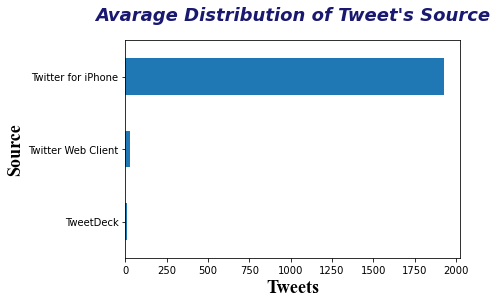

In [154]:
master_data.source.value_counts().sort_values().plot(kind ='barh')
plt.title("Avarage Distribution of Tweet's Source",fontsize = 18 ,pad=20 ,color='MidnightBlue',fontstyle= 'oblique',fontweight ='extra bold' ,fontfamily='sans-serif',fontvariant='small-caps')
plt.ylabel('Source',fontsize = 18,fontweight ='bold',fontfamily= 'times new roman')
plt.xlabel("Tweets",fontsize = 18,fontweight ='bold',fontfamily= 'times new roman')

plt.savefig('images/Av_dist_tweet_source.png')

In [155]:
source_retweet = master_data.groupby(['source']).retweet_count.mean()
source_favorite = master_data.groupby(['source']).favorite_count.mean()

### Interaction and avarage distribution of retweets and favorites across tweet sources

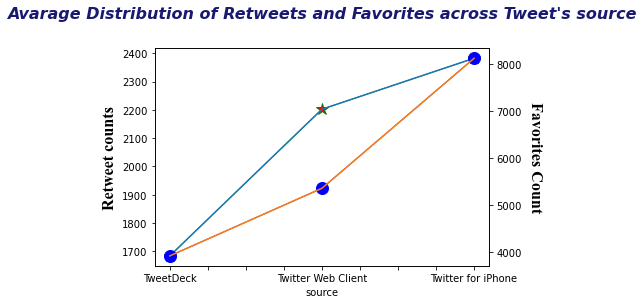

In [157]:
fig, ax1 = plt.subplots()
source_retweet.plot(ax=ax1, color='g',marker='*', markerfacecolor='red', markersize=12, linewidth=1)
source_favorite.plot(secondary_y=True, ax=ax1,marker='o', markerfacecolor='blue', markersize=12, color='b', linewidth=1)
ax = source_retweet.plot(); 
ax.set_ylabel('Retweet counts', fontsize=16,fontweight ='bold',fontfamily= 'times new roman');
source_favorite.plot(ax=ax, secondary_y=True);
plt.title("Avarage Distribution of Retweets and Favorites across Tweet's source",fontsize=16, pad=30 ,color='MidnightBlue',fontstyle= 'oblique' ,fontfamily='sans-serif',fontvariant='small-caps',fontweight ='extra bold')
plt.xlabel('Source', fontsize=16,fontweight ='bold',fontfamily= 'times new roman')
plt.ylabel('Favorites Count', fontsize=16, rotation=-90 ,labelpad=20,fontweight ='bold',fontfamily= 'times new roman')

plt.savefig('images/avarage distribution of retweets and favorites across tweet sources.png')

the graph shows us that the majority of the users are common Iphone users, big porotion of the source tweet comes through the Iphone Twitter, we can check it further and exmine the timeline of this usage across time and the changes occured in this time-period b/w varous platforms.

## note needed

## Most popular day/month to post a dog photo

In [158]:
# extract the month name
master_data['month'] = master_data.timestamp.apply(lambda x: x.month_name())
#extarct the day_name
master_data['week_day'] = master_data.timestamp.apply(lambda x: x.day_name())

In [159]:
# check for the top 5 rows in columns timestamp, day_name and month
master_data.loc[:5,['timestamp','week_day','month']]

,timestamp,week_day,month
0,2017-08-01 16:23:56,Tuesday,August
1,2017-08-01 00:17:27,Tuesday,August
2,2017-07-31 00:18:03,Monday,July
3,2017-07-30 15:58:51,Sunday,July
4,2017-07-29 16:00:24,Saturday,July
5,2017-07-29 00:08:17,Saturday,July


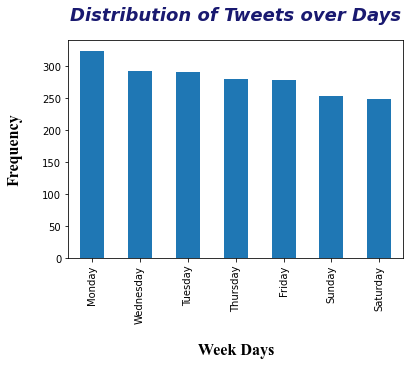

In [160]:
master_data.week_day.value_counts().plot(kind = 'bar')
plt.title("Distribution of Tweets over Days",fontsize = 18 ,pad=20 ,color='MidnightBlue',fontstyle= 'oblique',fontweight ='extra bold' ,fontfamily='sans-serif',fontvariant='small-caps')
plt.xlabel('Week Days',fontsize = 16,fontweight ='bold',labelpad=20,fontfamily= 'times new roman')
plt.ylabel('Frequency',fontsize = 16,fontweight ='bold',labelpad=20,fontfamily= 'times new roman')

plt.savefig('images/Distribution of Tweets over Days.png')

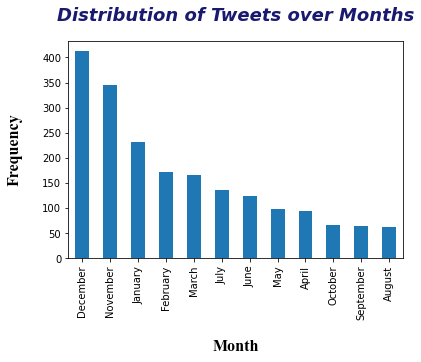

In [161]:
master_data.month.value_counts().plot(kind = 'bar')
plt.title("Distribution of Tweets over Months",fontsize = 18 ,pad=20 ,color='MidnightBlue',fontstyle= 'oblique',fontweight ='extra bold' ,fontfamily='sans-serif',fontvariant='small-caps')
plt.xlabel('Month',fontsize = 16,fontweight ='bold',labelpad=20,fontfamily= 'times new roman')
plt.ylabel('Frequency',fontsize = 16,fontweight ='bold',labelpad=20,fontfamily= 'times new roman')

plt.savefig('images/Distribution of Tweets over months.png')

## Most common breed

In [162]:
common_breed = master_data.groupby('breed_dog').filter(lambda x: len(x) >=20)
the_names= common_breed['breed_dog'].sort_values(ascending=False)

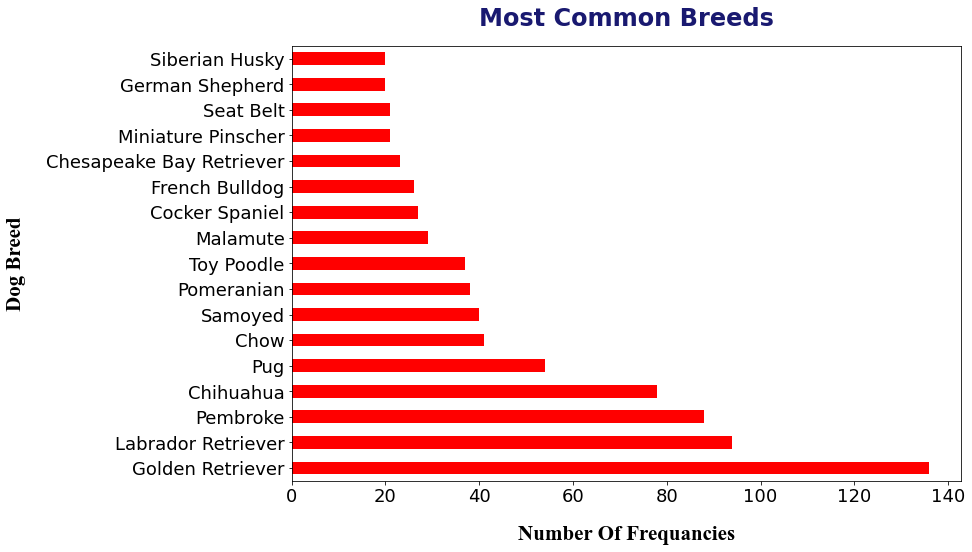

In [163]:
common_breed = master_data.groupby('breed_dog').filter(lambda x: len(x) >=20)
common_breed['breed_dog'].value_counts().plot(kind= 'barh', figsize=(12, 8) , fontsize= 18 , color='red')
plt.title('Most Common Breeds',fontsize = 24 ,pad=20,fontweight ='extra bold',color='MidnightBlue')
plt.xlabel('Number Of Frequancies',fontsize = 21,fontweight ='bold',fontfamily= 'times new roman',labelpad=20)
plt.ylabel('Dog Breed',fontsize = 21,fontweight ='bold',fontfamily= 'times new roman',labelpad=20)

plt.savefig('images/Most common breed.png')

## Interaction With Different Dog breeds

In [164]:
common_names= common_breed['breed_dog']

In [165]:
dog_retweet = master_data.groupby(common_names).retweet_count.mean().sort_values()
dog_favorite = master_data.groupby(common_names).favorite_count.mean().sort_values()

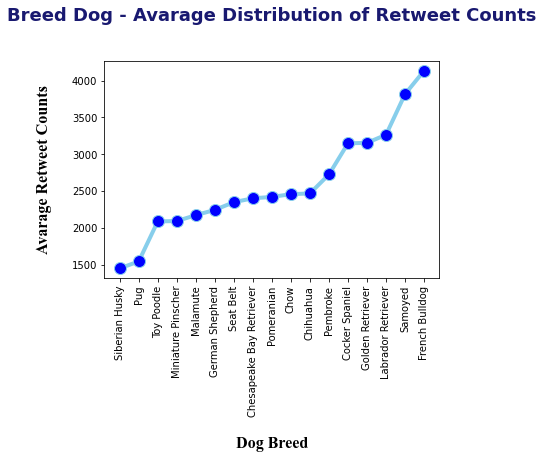

<Figure size 2160x1728 with 0 Axes>

In [166]:
ind = np.arange(len(dog_retweet))
plt.plot(dog_retweet, data=common_breed, marker='o', markerfacecolor='blue', markersize=12, color='skyblue', linewidth=4 )
plt.title('Breed Dog - Avarage Distribution of Retweet Counts',fontsize = 18 ,pad=40 ,fontweight ='extra bold',color='MidnightBlue')
plt.xlabel('Dog Breed',fontsize = 16,fontweight ='bold',fontfamily= 'times new roman',labelpad=20)
plt.ylabel('Avarage Retweet Counts',fontsize = 16,fontweight ='bold',fontfamily= 'times new roman',labelpad=20)
plt.xticks(rotation='vertical')
plt.figure(figsize=(30,24))

plt.savefig('images/Breed Dog - Avarage Distribution of Retweet Counts.png')

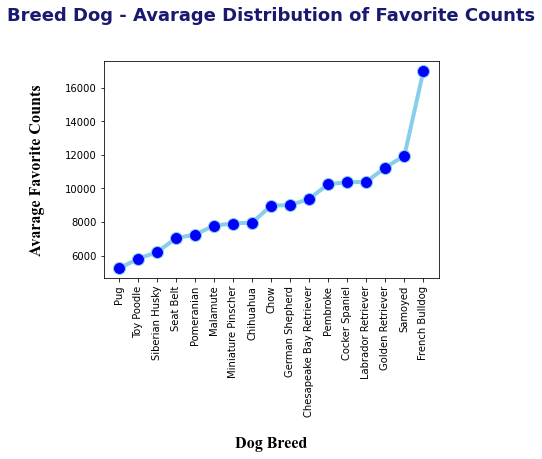

In [167]:
plt.plot(dog_favorite, data=common_breed, marker='o', markerfacecolor='blue', markersize=12, color='skyblue', linewidth=4)
plt.title('Breed Dog - Avarage Distribution of Favorite Counts',fontsize = 18 ,pad=40,fontweight ='extra bold',color='MidnightBlue')
plt.xlabel('Dog Breed',fontsize = 16,fontweight ='bold',fontfamily= 'times new roman',labelpad=20)
plt.ylabel('Avarage Favorite Counts',fontsize = 16,fontweight ='bold',fontfamily= 'times new roman',labelpad=20)
plt.xticks(rotation='vertical')

plt.savefig('images/Breed Dog - Avarage Distribution of Favorite Counts')

## Most common Dog name

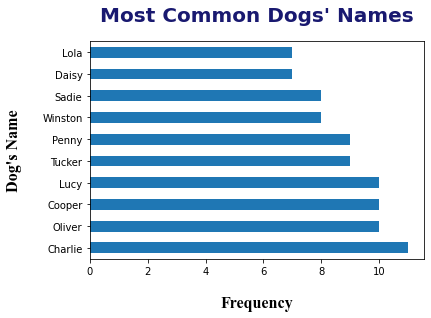

In [168]:
#rank the names frequency in a descending order
master_data.name.value_counts().sort_values(ascending =False)[:10].plot(kind='barh')
plt.title("Most Common Dogs' Names",pad =20,fontweight ='extra bold',fontsize = 20,color='MidnightBlue')
plt.xlabel('Frequency',labelpad =20,fontweight ='bold',fontfamily= 'times new roman',fontsize = 16)
plt.ylabel("Dog's Name",labelpad =20,fontweight ='bold',fontfamily= 'times new roman',fontsize = 16);

plt.savefig('images/Most Common Dogs name.png')

## most common Dog stage

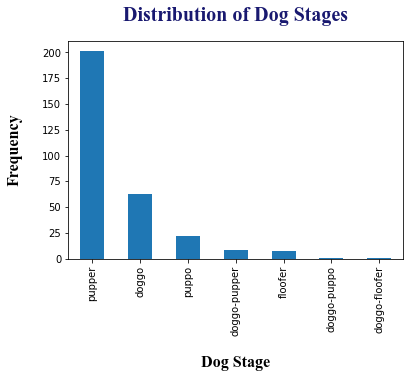

In [169]:
master_data.dog_stage.value_counts().plot(kind='bar')
plt.title("Distribution of Dog Stages",pad =20,fontweight ='extra bold',fontfamily= 'times new roman',fontsize = 20,color='MidnightBlue')
plt.xlabel('Dog Stage',labelpad =20,fontweight ='bold',fontfamily= 'times new roman',fontsize = 16)
plt.ylabel('Frequency',labelpad =20,fontweight ='bold',fontfamily= 'times new roman',fontsize = 16);

plt.savefig('images/most common Dog stage.png')

###  note that some values for the dog stage is missed may be because not known 

## Rating Variance TimeSeries

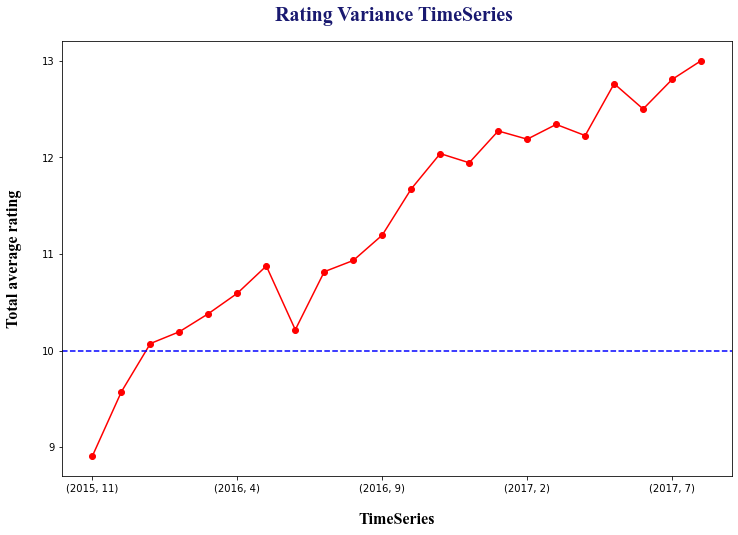

In [170]:
# trail is an example name for a dataframe to perform our  timeseries analysis
trail = master_data.copy()
trail.index = trail['timestamp']
trail.drop(columns= 'timestamp', inplace=True)
trail.sort_index(inplace=True)
trail = trail.groupby([(trail.index.year),(trail.index.month)]).rating_numerator.mean()
trail.plot(style='-ro', figsize=(12,8),label='Total average rating')

plt.axhline(y=10.0, color='b', linestyle='--', label='Out of rating')
plt.title("Rating Variance TimeSeries ",pad =20,fontweight ='extra bold',fontfamily= 'times new roman',fontsize = 20,color='MidnightBlue')
plt.xlabel('TimeSeries',labelpad =20,fontweight ='bold',fontfamily= 'times new roman',fontsize = 16)
plt.ylabel('Total average rating',labelpad =20,fontweight ='bold',fontfamily= 'times new roman',fontsize = 16)

plt.savefig('images/Rating Variance TimeSeries.png')

## Top retweeted and/or favorite dog

In [171]:
from PIL import Image

# get the winner who has the largest retweet_count and the favorite_count
max_retweet , max_favorite = master_data.favorite_count.groupby(master_data['retweet_count']).value_counts().\
                            sort_values(ascending=False).index[0]

winner = master_data.query('favorite_count == @max_favorite & retweet_count == @max_retweet')

r = requests.get(winner['jpg_url'].item())
i =Image.open(BytesIO(r.content))
i.save('winner.jpg')
# prin the final result
print(f"No of retweets is : {winner['retweet_count'].item()}, \nNo of favorite_count is {winner['favorite_count'].item()}")

No of retweets is : 74890.0, 
No of favorite_count is 151291.0


In [172]:
#check winner rating
winner['rating_numerator']

767    13.0
Name: rating_numerator, dtype: float64

In [173]:
winner_img= master_data['jpg_url'][767]
winner_img

'https://pbs.twimg.com/ext_tw_video_thumb/744234667679821824/pu/img/1GaWmtJtdqzZV7jy.jpg'

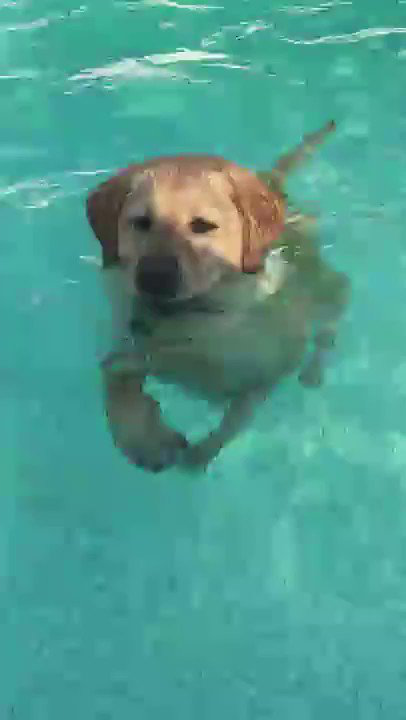

In [174]:
Image.open(requests.get(winner_img, stream=True).raw)

## Dog with highest rate

In [175]:
dog_highest_rate = master_data['rating_numerator'].idxmax()
dog_highest_rate

9

In [176]:
master_data['rating_numerator'].max(),master_data['retweet_count'][dog_highest_rate],master_data['favorite_count'][dog_highest_rate]

(14.0, 6431.0, 29076.0)

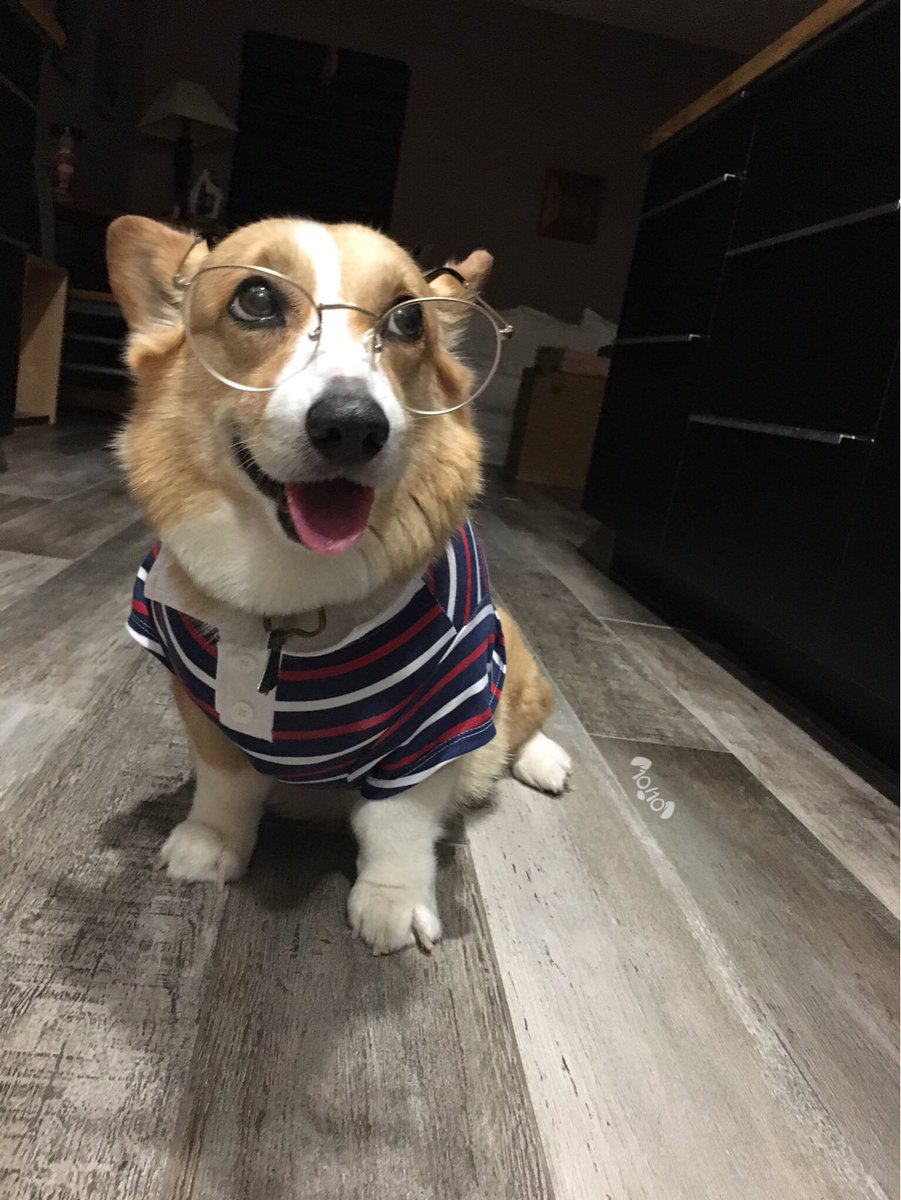

In [177]:
dog_highest_img= master_data['jpg_url'][dog_highest_rate]
Image.open(requests.get(dog_highest_img, stream=True).raw)

### Report Poster

In [178]:
import re
# cleaning text upon use to create poster
master_data['cleaned_text'] = master_data['text'].apply(lambda x: re.split('https:\/\/.*', str(x))[0])

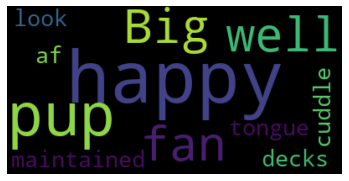

In [179]:
# Start with one review:
text = master_data.cleaned_text[1965]

# Create and generate a word cloud image:
wordcloud = WordCloud().generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

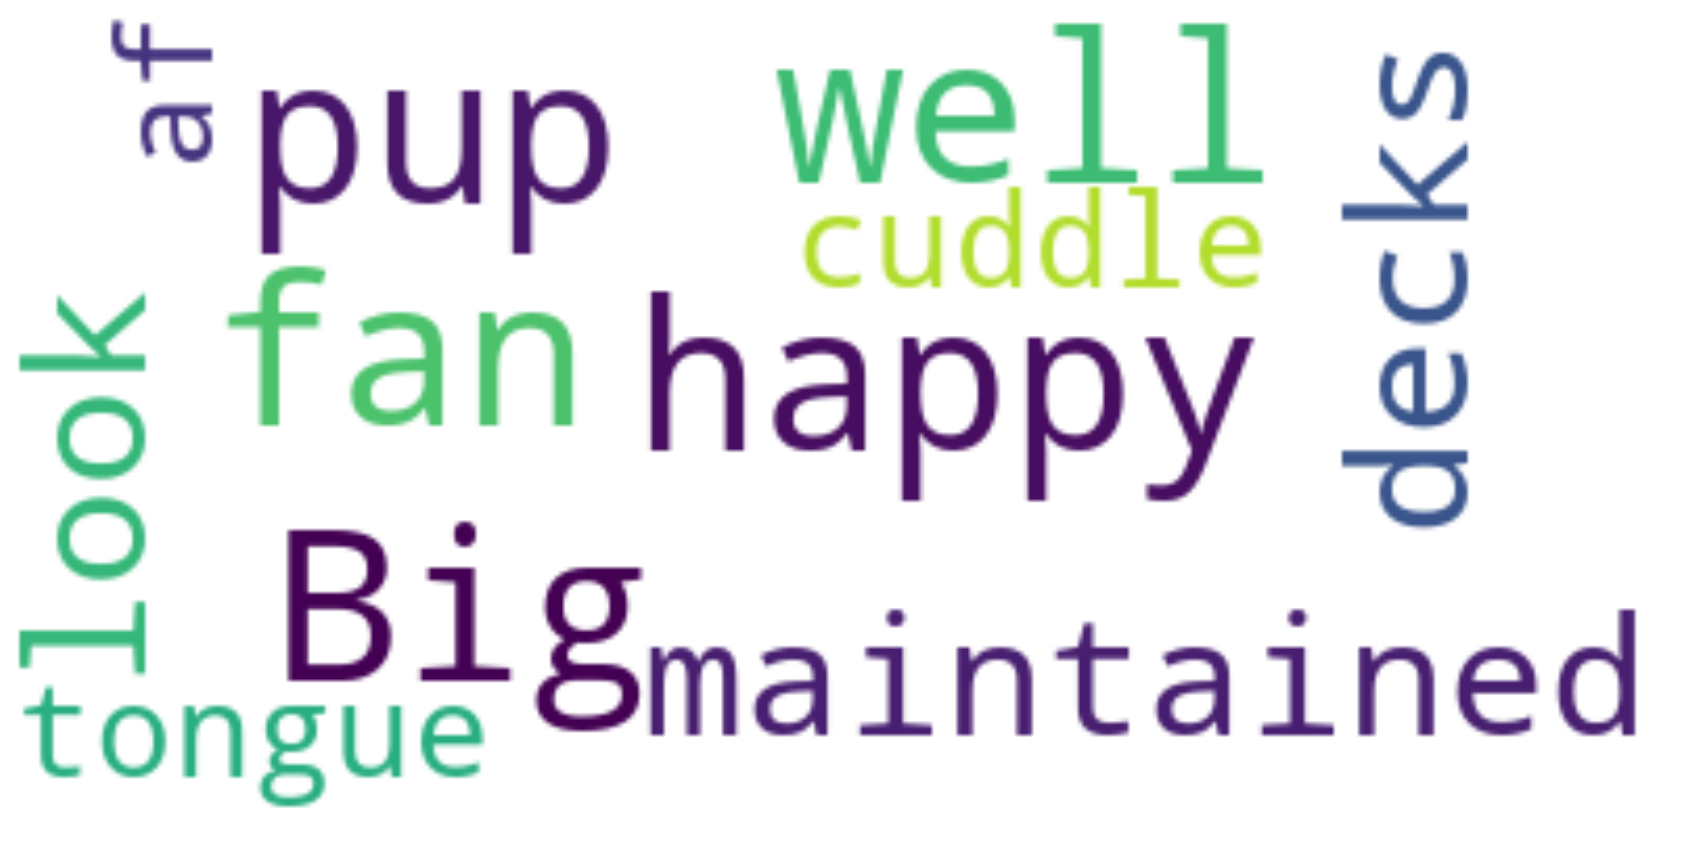

In [180]:
# lower max_font_size, change the maximum number of word and lighten the background:
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
plt.figure(figsize=(30,24))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [181]:
text = " ".join(review for review in master_data.cleaned_text)
print ("There are {} words in the combination of all review.".format(len(text)))

There are 197245 words in the combination of all review.


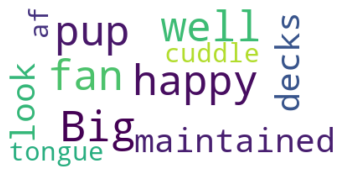

In [182]:
# Create stopword list:
stopwords = set(STOPWORDS)
stopwords.update(["af", "now", "ckin", "amp", "h"])

# Generate a word cloud image
wc = WordCloud(width=2200, height=1000,stopwords=stopwords, background_color="white").generate(text)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()
wc.to_file("images/cloud.png")

In [205]:
# download dog image 
url = 'https://www.clipartkey.com/mpngs/b/40-405451_pet-clip-art.png'
r = requests.get(url)
image = np.array(Image.open(BytesIO(r.content)))

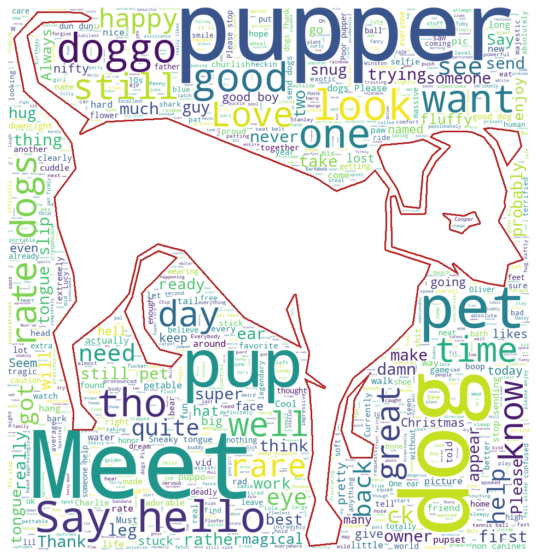

In [204]:
# Create a word cloud image
wc = WordCloud(background_color="white", max_words=1000, mask= image,
               stopwords=stopwords, contour_width=3, contour_color='firebrick')

# Generate a wordcloud
wc.generate(text)

# store to file
wc.to_file("images/wine.png")

# show
plt.figure(figsize=[20,10])
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()